# Training a neural network

Last week, we learned about tensors and modules in PyTorch. This week, we will go over all the steps to define a model for a certain learning task for a dataset and train it. You will learn to use PyTorch to:

- define or download the dataset and inspect it to understand the shape and type of input and output of the learning task (usually called x and y).
- define the model with the correct layers according to the shape and dtype of the input and output.
- define a loss function that is a quantitative metric for the performance of the model
- perform backpropagation to calculate the gradient of the loss with respect to all parameters
- update the model parameters using the calculated gradients
- automate the whole procedure in a training loop

In [1]:
# For interactive plotting:
import os
import matplotlib.pyplot as plt
import ipywidgets as widgets
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except ImportError:
    pass
try:
    %matplotlib widget
except:
    os.system('pip install ipympl -qq')
    %matplotlib widget

# tqdm is a nice library to create progress bars (we'll use it at the end)
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch import optim

# for datasets provided by pytorch:
from torchvision import datasets
# for transformations (preprocessing, augmentation, ...) we can apply to the datasets:
from torchvision.transforms import v2


# our very useful function to inspect a tensor:
def print_tensor_info(
        name: str, 
        tensor: torch.Tensor,
        ):
    print(f'{name}')
    print(20*'-')
    if not isinstance(tensor, torch.Tensor):
        print(f'It is {type(tensor).__name__}!')
        print(20*'='+'\n')
        return
    # print name, shape, dtype, device, require_grad
    print(f'shape: {tensor.shape}')
    print(f'dtype: {tensor.dtype}')
    print(f'device: {tensor.device}')
    print(f'requires_grad: {tensor.requires_grad}')
    print(20*'='+'\n')


# Check if cuda (GPU) is available
Device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {Device} device')

Using cuda device


## Dataset

In this notebook, we use a dataset from `torchvision`. You can find the available datasets in `torchvision.datasets` [here](https://pytorch.org/vision/0.8/datasets.html). As an example, we are going to download and use the USPS dataset. For each dataset, carefully read the documentation on how to download and use it.


In [2]:
train_data = datasets.USPS(
    root = 'week2-data', # where the data will be downloaded and stored
    train = True, # if you want the train data. pass False if you want the test data
    download = True, # download the data if you don't have it
    transform = v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
    ]) # data preprocessing and augmentation
)

test_data = datasets.USPS(
    root = 'week2-data', # where the data will be downloaded and stored
    train = False, # if you want the train data. pass False if you want the test data
    download = True, # download the data if you don't have it
    transform = v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
    ]) # data preprocessing and augmentation
)

The base class for a Dataset is `torch.nn.utils.data.Dataset` which we have imported as `Dataset` for convenience. All these available datasets are an instance of this class.

Spoiler: In this week's assignment, you will have to write your custom subclass of `Dataset`. 

In [3]:
isinstance(train_data, Dataset), isinstance(test_data, Dataset)

(True, True)

You can get the number of samples using `len(your_dataset)`. You can also index it to get a specific sample.

In [4]:
n_train = len(train_data)
n_test = len(test_data)

print(f"Number of train samples: {n_train}")
print(f"Number of test  samples: {n_test}")

Number of train samples: 7291
Number of test  samples: 2007


In [5]:
# Let's look at a sample from the training data
sample = train_data[0]
print_tensor_info('sample', sample)
x, y = sample
print_tensor_info('x', x)
print_tensor_info('y', y)

sample
--------------------
It is tuple!

x
--------------------
shape: torch.Size([1, 16, 16])
dtype: torch.float32
device: cpu
requires_grad: False

y
--------------------
It is int!



Let's ignore the first dimension for now. Each sample appears to be of size `(16,16)`, which means it is a 2D tensor, i.e. a matrix.Actually, the input is an image. Let's visualize the data using the main plotting library in python `matplotlib` and the `ipywidgets` library that is helpful to create an interactive interface to visualize the data.

In [6]:

class ImageDataViz:
    """
    An interactive image data visualzation tool inside Juptyer Notebook.
    Make sure to use the magic command: %matplotlib widget
    """
    def __init__(self, data: Dataset):
        self.data = data
        self.n_samples = len(data)
        self.index = widgets.IntSlider(
            value=0, 
            min=0, 
            max=self.n_samples-1, 
            step=1, 
            description='Index', 
            continuous_update=True,
            layout=widgets.Layout(width='40%'),
        )

    def update(self, index: int):
        x, y = self.data[index]
        image = x.moveaxis(0, -1).squeeze().numpy()
        self.img.set_data(image)
        self.ax.set_title(f'Label: {y}')

    def show(self):
        self.fig, self.ax = plt.subplots()
        x, y = self.data[0]
        image = x.moveaxis(0, -1).squeeze().numpy()
        self.img = self.ax.imshow(image)
        self.ax.axis('off')
        self.ax.set_title(f'Label: {y}')
        widgets.interact(self.update, index=self.index)
        

interactive(children=(IntSlider(value=0, description='Index', layout=Layout(width='40%'), max=7290), Output())…

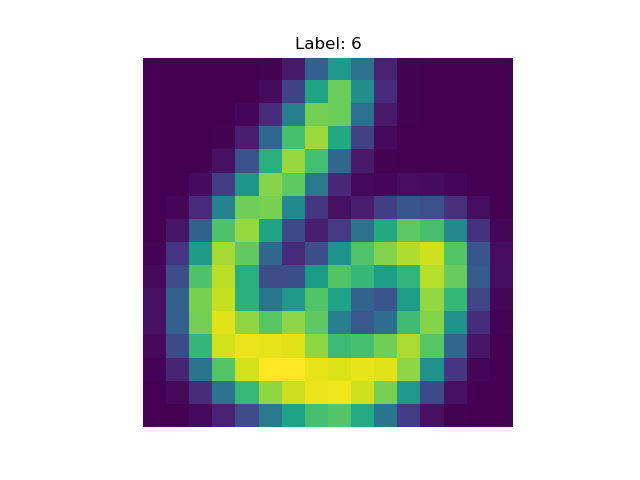

In [7]:
viz = ImageDataViz(train_data)
viz.show()

We can see that this dataset consists of `(16, 16)` grayscale images of digits with their corresponding digit as a label saved as an integer. The first dimension that we ignored before is known as the channel dimension. You will get more familiar with this concept in the upcoming weeks when learning more about image data and convilutional neural networks. For now, know that grayscale images have one channel and color images (RGB) usually have 3 channels for Red, Green and Blue.

## Dataloader for batching the data

As you have learned, data is usually used as mini-batches in deep learning. In the code, we simply call them batches. You can choose the batch_size to be 1 (a single sample at a time), n_train (all the dataset), or a more reasonable number in between. Usually batch size is set to 32, 64, or 128. Choosing a power of two is best to optimize hardware utilization.

The tool that PyTorch provides us to batch the data and go over the batches one by one and feed them to our model is `torch.utils.data.DataLoader` which we imported as `DataLoader`. Using it is pretty simple: you pass in your dataset, specify the batch_size, whether you want to shuffle it in each epoch (one full pass over the dataset), and some other optional choices. Let's see an example:

In [8]:
train_loader = DataLoader(
    train_data,
    batch_size = 32,
    shuffle = True, # shuffle the data before each epoch
    drop_last = True, # The last batch may not be of the same size as the previous ones. If you want to drop it, set this to True
)

test_loader = DataLoader(
    test_data,
    batch_size = 32,
    shuffle = False, # no need to shuffle the test data
)

"""
Typically, the way to use the dataloader is to loop over it to get the batches one by one.
Here is how you can do it:


The full loop is called an epoch. It is the number of times you loop over the entire dataset.
For now, we'll just use one batch and show how it works and what it gives us.
"""
for batch in train_loader:
    x, y = batch
    break # We don't to loop over all the batches for now. This was just for demonstration

print_tensor_info('batch', batch)
print_tensor_info('batched x', x)
print_tensor_info('batched y', y)


# Another way to get the next batch without the for loop ane the break:
# We'll work with this single batch for now to go over the steps
batch = next(iter(train_loader))
x, y = batch

print_tensor_info('batch', batch)
print_tensor_info('batched x', x)
print_tensor_info('batched y', y)

batch
--------------------
It is list!

batched x
--------------------
shape: torch.Size([32, 1, 16, 16])
dtype: torch.float32
device: cpu
requires_grad: False

batched y
--------------------
shape: torch.Size([32])
dtype: torch.int64
device: cpu
requires_grad: False

batch
--------------------
It is list!

batched x
--------------------
shape: torch.Size([32, 1, 16, 16])
dtype: torch.float32
device: cpu
requires_grad: False

batched y
--------------------
shape: torch.Size([32])
dtype: torch.int64
device: cpu
requires_grad: False



## Define the model
You need important information from the dataset before you can implement your model, most importantly the shape and dtype of input and output. In our example, we will use a simple softmax regression (one layer only) to classify the image as the correct digit it represents. But how do we apply a linear layer to a 2D image? An easy way is to flatten the whole tensor as a long vector (1D tensor) first. After flattening, we will have a `16*16` vector, and that is going to be the `in_features` for the linear module. The `out_features` should be the number of classes (why?). The softmax is not explicitly applied, because we are going to use `nn.CrossEntropyLoss()`, which takes logits (the outputs before softmax). Since the argmax of the output does not change if we apply softmax, we can directly get the predicted class from the logits and we do not need the softmax. `nn.CrossEntropyLoss()` combines the softmax and the loss into one module because of some benefits in terms of the numerical stability and computational efficiency.

In [9]:
model = nn.Sequential(
    # First, we flatten the 2D image into a long vector
    nn.Flatten(start_dim=1), # because dim=0 is the batch dimension
    nn.Linear(16*16, 10), # 16*16 is the size of the image, and 10 is the number of classes
).to(Device) # don't forget to move the model to the device


x, y = next(iter(train_loader))
# always remember to move the data to the correct device and dtype

"""
Move the data to the device and the correct dtype.
Then, pass the input to the model to get the output.
"""

# Test the model with the batch. You should not get an error.
x = x.to(device=Device, dtype=torch.float32) # the input should be on the same device as the model.
y_pred = model(x)

print_tensor_info('y_pred', y_pred)

# For comparison:
print_tensor_info('y', y)

# You can inspect the content of these tensors to see what they look like as well!


y_pred
--------------------
shape: torch.Size([32, 10])
dtype: torch.float32
device: cuda:0
requires_grad: True

y
--------------------
shape: torch.Size([32])
dtype: torch.int64
device: cpu
requires_grad: False



## Loss function

The next step is to define the objective you want to optimize. Usually, the objective is defined as a loss function (the lower, the better) that is minimized in training. Since this is a multi-class classification, we need a cross entropy loss. You can define your loss function anyway you want, as long as it represents a metric measuring the divergence of the model prediction from the output. However, some specific loss functions are better suited for some properties and have desirable convergence properties and so on. For example, a commonly used loss function for multi-class classification is the cross entropy loss, and it's already available in PyTorch. Let's see how to define and use it: 

In [10]:
#######################################################################
# Components:

model = nn.Sequential(
    # First, we flatten the 2D image into a long vector
    nn.Flatten(
        start_dim=1, # because dim=0 is the batch dimension
    ),
    nn.Linear(16*16, 10), # 16*16 is the size of the image, and 10 is the number of classes
).to(Device) # don't forget to move the model to the device

loss_fn = nn.CrossEntropyLoss(
    reduction = 'mean', # the loss is averaged over the batch. You can also choose 'sum' or 'none'.
)

#######################################################################
# Training: 

x, y = next(iter(train_loader))
x = x.to(device=Device, dtype=torch.float32) # the input should be on the same device as the model.
y = y.to(device=Device, dtype=torch.long) # device should be the same as the model output for the loss function to work
# The dtype should also be correct. In this case, the loss function expects a long tensor

# forward pass
y_pred = model(x)

"""
Let's compute the loss and see what it looks like
"""

# compute the loss
# y_pred and y should be on the same device, and their shape and dtype should be correct for the loss function (look at the documentation)
loss = loss_fn(y_pred, y)
print_tensor_info('loss', loss)


loss
--------------------
shape: torch.Size([])
dtype: torch.float32
device: cuda:0
requires_grad: True



## Backpropagation (backward pass)

Backpropagation was the difficult part in the old days. Now, it is done in one line. In general, all your calculations in PyTorch are tracked as a **computational graph**, which is a data structure used for automatic differentiation and executing backpropagation using the chain rule. All tensors that have `requires_grad=True` will have their `grad` attribute updated once you perform the backpropagation. After that, you can use the gradients to update your paramters using Stochastic Gradient Descent or any optimizer you fancy (Adam, AdamW, ...). 

Performing backpropagation is simple. Just call `.backward()` on the quantity that you want to take the derivate of (with respect to all parameters involved in its calculation that have `requires_grad=True`). Let's go over an example and look at a specific parameter of the model and see what happens.

In [11]:
##################################################
# Components:

model = nn.Sequential(
    nn.Flatten(
        start_dim=1, # because dim=0 is the batch dimension
    ),
    nn.Linear(16*16, 10)
).to(Device)

loss_fn = nn.CrossEntropyLoss(reduction='mean')

##################################################
# Training:

x, y = next(iter(train_loader))
x = x.to(device=Device, dtype=torch.float32)
y = y.to(device=Device, dtype=torch.long)

# forward pass
y_pred = model(x)

# compute the loss
loss = loss_fn(y_pred, y)


"""
Let's do backprop and see what happens!
"""

# Since the backpropagation is not done yet, the gradients are None
print_tensor_info('model[1].weight.grad before backprop', model[1].weight.grad)

# Let's do the backpropagation
loss.backward() # this simple line takes care of the backpropagation! Cool, right?

# Now let's look at the gradient
print_tensor_info('model[1].weight.grad after backprop', model[1].weight.grad)

# Let's look at the parameter itself:
print_tensor_info('model[1].weight', model[1].weight)

# grad is the same shape as the parameter itself! and the same dtype and device!

model[1].weight.grad before backprop
--------------------
It is NoneType!

model[1].weight.grad after backprop
--------------------
shape: torch.Size([10, 256])
dtype: torch.float32
device: cuda:0
requires_grad: False

model[1].weight
--------------------
shape: torch.Size([10, 256])
dtype: torch.float32
device: cuda:0
requires_grad: True



## update parameters using the gradients

After you have performed the backpropagation (also called backward pass), you can use the gradients to update the parameters. This is done using the `optim` class in PyTorch. To use an optimizer, you have to give it the parameters it has to optimize, as well as optional optimizer hyperparameters. You can find more about all different optimizers and their configurations and how to use them [here](https://pytorch.org/docs/stable/optim.html). For now, let's use the simple stochastic gradient descent (SGD) as an example.

In [12]:
####################################################
# Components

model = nn.Sequential(
    nn.Flatten(
        start_dim=1, # because dim=0 is the batch dimension
    ),
    nn.Linear(16*16, 10)
).to(Device)

loss_fn = nn.CrossEntropyLoss(reduction='mean')

"""
The final component is the optimizer. Let's use SGD (normal stochastic gradient descent).
"""

optimizer = optim.SGD(
    model.parameters(), # pass the parameters of the model to the optimizer
    lr = 0.001, # Optional: learning rate. Default is 0.001 (can be found in the documentation)
)

####################################################
# Training

x, y = next(iter(train_loader))
x = x.to(device=Device, dtype=torch.float32)
y = y.to(device=Device, dtype=torch.long)

# forward pass
y_pred = model(x)

# compute the loss
loss = loss_fn(y_pred, y)

# backward pass
loss.backward() 

"""
Now it's time to update the parameters using SGD.
The optimizer has a method called step() that does the update for you.
To show you what happens, we'll also do the update manually and compare the results.
"""

# let's choose a certain weight and implement the update manually. Then we'll compare the results!

# MANUALLY:
# We should use .clone() to not point to the actual tensors and create a copy instead!
w_before = model[1].weight.clone()
w_before_grad = model[1].weight.grad.clone()

# The manual gradient step
w_after = w_before - 0.001 * w_before_grad

# Now let's do the update using the optimizer.
optimizer.step()

# Now let's compare the results
if torch.allclose(w_after, model[1].weight):
    print('Both did the same thing!')

Both did the same thing!


## Putting everything together

Now that we have everything we need, let's define our model and write a full training epoch. Some new things are added here. Look carefully to spot them and understand what they do.

In [13]:
# Components
model = nn.Sequential(
    nn.Flatten(
        start_dim=1, # because dim=0 is the batch dimension
    ),
    nn.Linear(16*16, 10)
).to(Device)

train_loader = DataLoader(
    train_data,
    batch_size = 8, # let's use a small batch size
    shuffle = True,
    drop_last = True,
)

loss_fn = nn.CrossEntropyLoss(reduction='mean')

optimizer = optim.SGD(
    model.parameters(),
    lr = 0.001,
)

In [14]:
# Define a train_epoch function that trains the model for one epoch
# An epoch is a full pass over the entire dataset

@torch.enable_grad()
def train_epoch(
        model: nn.Module,
        train_loader: DataLoader,
        loss_fn: callable,
        optimizer: optim.Optimizer,
        device: str,
        ) -> float:

    # Always set the model to train mode first.
    # Some layers behave differently in train and test mode.
    # You will learn about these layers later (example: dropout, batchnorm)
    model.train()

    # define a progress bar using tqdm:
    batch_pbar = tqdm(
        train_loader, # The iterable to loop over
        desc = 'training', # the description of the progress bar
        unit = 'batch', # the unit to display
        leave = True, # if you want the progress bar to disappear after it's done, set leave=False.
        )

    # Loop over the batches using the progress bar
    for x, y in batch_pbar:
        # Move the data to the device and dtype
        x = x.to(device=device, dtype=torch.float32)
        y = y.to(device=device, dtype=torch.long)

        # now we have to clear the gradients of all trainable tensors
        # Why: because the gradients are accumulated for parameters that are used several times
        # (example: recurrent neural networks)
        # If you don't clear them, they will accumulate and affect the next batch
        optimizer.zero_grad()
        # you can also call .zero_grad() on the model itself

        # forward pass
        y_pred = model(x)

        # compute the loss
        loss = loss_fn(y_pred, y)

        # backward pass (backpropagation)
        loss.backward()

        # update the parameters
        optimizer.step()

        # update the progress bar
        # loss.item() returns the scalar value of a dimension 0 tensor as a Python number
        # We can report the live loss value in the progress bar
        # This is very useful to see if the model is converging
        batch_pbar.set_postfix_str(f'loss={loss.item():.4f}')

In [15]:
# Let's ry to train the model for an epoch:
train_epoch(model, train_loader, loss_fn, optimizer, Device)

training: 100%|██████████| 911/911 [00:04<00:00, 191.92batch/s, loss=1.9583]


That is one epoch of training. Usually, training is done for a certain number of epochs, or a certain number of iterations (calls to `optimizer.step()`), which may be more fair when we want to compare models that were trained on different portions of the data. The same number of epochs would not be fair, but the same number of iterations give both models an equal opportunity to do their best with the avaialbe data to them to be trained.

Usually, you need additional code to keep track of your training loss to see if the model is converging! You also should keep track of your validation loss to look out for overfitting and tuning your hyperparameters! You will learn more in this week's assignment!


Finally, let's write a full loop that trains the model for multiple epochs. We also introduce another tool here, the learning rate scheduler. You will get to explore different optimizers and learning rate schedulers in your assignments. You will get more familiar with different optimizers next week.

In [16]:
def train(
        model: nn.Module,
        train_loader: DataLoader,
        loss_fn: callable,
        optimizer: optim.Optimizer,
        lr_scheduler: optim.lr_scheduler._LRScheduler,
        device: str,
        n_epochs: int,
        ) -> None:
    
    epoch_pbar = tqdm(
        range(n_epochs),
        desc = 'training',
        unit = 'epoch',
        leave = False,
        )
    
    for epoch in epoch_pbar:

        running_avg_train_loss = 0.0

        for x, y in train_loader:

            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)

            optimizer.zero_grad()
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()

            running_avg_train_loss += loss.item() * x.shape[0]

        running_avg_train_loss /= len(train_loader.dataset)

        if isinstance(lr_scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            lr_scheduler.step(running_avg_train_loss)
        elif lr_scheduler is not None:
            lr_scheduler.step()

        epoch_pbar.set_postfix_str(f'running avg train loss = {running_avg_train_loss:.4f}')

In [17]:
# define the model, loss function, optimizer, and learning rate scheduler

model = nn.Sequential(
    nn.Flatten(start_dim=1),
    nn.Linear(16*16, 10),
).to(Device)

loss_fn = nn.CrossEntropyLoss(reduction='mean')

optimizer = optim.SGD(model.parameters(), lr=0.001)
# optimizer = optim.Adam(model.parameters(), lr=0.002)
# optimizer = optim.AdamW(model.parameters(), lr=0.004)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
# lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20, 30], gamma=0.1)

# train the model for 100 epochs
train(
    model = model,
    train_loader = train_loader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    lr_scheduler = lr_scheduler,
    device = Device,
    n_epochs = 20,
    )